<a href="https://colab.research.google.com/github/salomemeskhishvili/final-project-AI-sm/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd  #იმპორტები
import numpy as np
import torch
import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
!pip install evaluate
!pip install -q transformers datasets evaluate gradio accelerate scikit-learn matplotlib
import evaluate
import gradio as gr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.0 MB/s eta 0:00:00


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
dataset = load_dataset("Arseniy-Sandalov/Georgian-Sentiment-Analysis")
print(dataset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Dataset.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/4219 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'sentiment', 'perturbation'],
        num_rows: 4219
    })
})


In [51]:
import re

def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # ვწმენდ დატას და ვშლი ლინკებს
    text = re.sub(r'\s+', ' ', text).strip() # ზედმეტი სფეისების წაშლა
    return text

dataset = dataset.map(lambda x: {"text": clean_text(x["text"])})

Map:   0%|          | 0/3130 [00:00<?, ? examples/s]

Map:   0%|          | 0/783 [00:00<?, ? examples/s]

In [5]:
dataset['train'][0] #შევამოწმე მუშაობა

{'text': 'ამჟამად, სამაშველო და სტიქიის შედეგების სალიკვიდაციო სამუშაოები მიმდინარეობს, რომელშიც მერიის სამსახურებთან და შსს-ის დანაყოფებთან ერთად ასევე ჩართულია თავდაცვის სამინისტროს პირადი შემადგენლობა',
 'sentiment': 'Positive',
 'perturbation': None}

In [6]:
dataset = dataset.filter(lambda x: x["sentiment"] in ["Negative", "Neutral", "Positive"])

Filter:   0%|          | 0/4219 [00:00<?, ? examples/s]

In [52]:
dataset_no_mixed = dataset.filter(   ## ამოვშალე mixed ტექსტი
    lambda x: x["sentiment"] in ["Negative", "Neutral", "Positive"]
)

Filter:   0%|          | 0/3130 [00:00<?, ? examples/s]

Filter:   0%|          | 0/783 [00:00<?, ? examples/s]

In [8]:
from collections import Counter  #შევამოწმე

labels = [ex["sentiment"] for ex in dataset_no_mixed['train']]
Counter(labels)

Counter({'Positive': 765, 'Negative': 1417, 'Neutral': 1731})

In [53]:
def filter_labels(example): # მივანიჭე Labels
    return example['sentiment'] in ["Negative", "Neutral", "Positive"]

dataset['train'] = dataset['train'].filter(filter_labels)

Filter:   0%|          | 0/3130 [00:00<?, ? examples/s]

In [10]:
label_mapping = {"Negative":0, "Neutral":1, "Positive":2}
def encode_labels(example):
    example["label"] = label_mapping[example["sentiment"]]
    return example

In [11]:
dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)
train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [13]:
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [14]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/3130 [00:00<?, ? examples/s]

Map:   0%|          | 0/783 [00:00<?, ? examples/s]

In [17]:
split_data = dataset["train"].train_test_split(test_size=0.2, seed=42)

train_dataset = split_data["train"]
test_dataset = split_data["test"]

print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")

model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

Train size: 2504, Test size: 626


Map:   0%|          | 0/2504 [00:00<?, ? examples/s]

Map:   0%|          | 0/626 [00:00<?, ? examples/s]

In [54]:
from sklearn.utils.class_weight import compute_class_weight

# ვითვლით წონებს
labels = train_dataset["label"]
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to("cuda" if torch.cuda.is_available() else "cpu")

In [55]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=weights_tensor)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [20]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
model.to("cuda" if torch.cuda.is_available() else "cpu")

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

In [56]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to=[]
)

In [71]:
accuracy = evaluate.load("accuracy")  #ვიყენებ accuracy-ს
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)

In [23]:
# დავყავი კლასების მიხედვით
negatives = dataset['train'].filter(lambda x: x['label']==0)
neutrals  = dataset['train'].filter(lambda x: x['label']==1)
positives = dataset['train'].filter(lambda x: x['label']==2)

from datasets import concatenate_datasets

def oversample(ds, target_len):
    repeat_factor = (target_len // len(ds)) + 1
    return concatenate_datasets([ds]*repeat_factor).select(range(target_len))

target_len = max(len(negatives), len(neutrals), len(positives))
negatives = oversample(negatives, target_len)
positives = oversample(positives, target_len)

train_dataset = concatenate_datasets([negatives, neutrals, positives]).shuffle(seed=42)

print("Train dataset balance:", Counter(train_dataset['label']))


Filter:   0%|          | 0/3130 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3130 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3130 [00:00<?, ? examples/s]

Train dataset balance: Counter({0: 1399, 1: 1399, 2: 1399})


In [57]:
from torch.nn import CrossEntropyLoss
from collections import Counter
import torch

# კლასების რაოდენობა
class_counts = Counter(tokenized_train['label'])
print("Class counts:", class_counts)

# მხოლოდ არსებული კლასები
weights_list = []
for i in range(3):
    if class_counts[i] > 0:
        weights_list.append(sum(class_counts.values()) / class_counts[i])
    else:
        weights_list.append(0.0)  # თუ კლასში მონაცემი არ არის, weight 0
weights = torch.tensor(weights_list).to(device)

print("Weights:", weights)

Class counts: Counter({1: 1119, 0: 896, 2: 489})
Weights: tensor([2.7946, 2.2377, 5.1207], device='cuda:0')


In [50]:
from datasets import Dataset, DatasetDict

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


/tmp/ipython-input-3894578645.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


In [62]:
from accelerate import Accelerator
import gc

try:
    del model
    del trainer
except:
    pass

gc.collect()
torch.cuda.empty_cache()
Accelerator().free_memory()

print("მეხსიერება გასუფთავდა")

model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=3)
model.to("cuda" if torch.cuda.is_available() else "cpu")

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to=[]
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

print("ტრენინგი მიდის...")
trainer.train()

trainer.save_model("./final_best_model")
print("მოდელი შეინახა")

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


მეხსიერება გასუფთავდა


/tmp/ipython-input-51038006.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


ტრენინგი მიდის...


Step,Training Loss,Validation Loss,Accuracy
50,No log,0.996263,0.453674
100,No log,0.919149,0.595847
150,No log,0.830930,0.662939
200,No log,0.749558,0.702875
250,No log,0.720325,0.702875
300,No log,0.831463,0.678914
350,No log,0.778191,0.728435
400,No log,0.713198,0.736422
450,No log,0.643331,0.758786
500,0.788400,0.715634,0.753994


მოდელი შეინახა


In [28]:
trainer.save_model("./my_final_model")
print("Model saved")

Model saved


In [42]:
from tqdm.auto import tqdm

tokenized_test.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
# ვამოწმებ შეცდომებს რომ accuracy ავამაღლო
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

wrong_preds = []
id2label = {0: "Negative", 1: "Neutral", 2: "Positive"}

print("შეცდომების ძებნა...")

for i in tqdm(range(len(tokenized_test))):

    inputs = {
        "input_ids": tokenized_test[i]["input_ids"].unsqueeze(0).to(device),
        "attention_mask": tokenized_test[i]["attention_mask"].unsqueeze(0).to(device)
    }

    true_label = tokenized_test[i]["label"].item() # .item() სჭირდება, რომ რიცხვი ამოვიღოთ

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    pred_label = torch.argmax(logits, dim=-1).item()

    if pred_label != true_label:
        text = tokenizer.decode(tokenized_test[i]["input_ids"], skip_special_tokens=True)

        wrong_preds.append({
            "Text": text,
            "True Label": id2label[true_label],
            "Predicted Label": id2label[pred_label]
        })

df_errors = pd.DataFrame(wrong_preds)

print(f"\nსულ ნაპოვნია {len(df_errors)} შეცდომა.")
print("-" * 50)
if len(df_errors) > 0:
    display(df_errors.head(10))
else:
    print("ყოჩაღ! არცერთი შეცდომა არ უპოვია)")

შეცდომების ძებნა...


  0%|          | 0/626 [00:00<?, ?it/s]


სულ ნაპოვნია 151 შეცდომა.
--------------------------------------------------


,Text,True Label,Predicted Label
0,მასშტაბური ანტიტერორისტული ოპერაცია ქვეყნის რა...,Positive,Negative
1,"მისი თქმით, საქართველო მზად არის, აქტიურად ითა...",Neutral,Positive
2,"საპროტესტო აქცია ჯერ კიდევ მიმდინარეობდა, როდე...",Neutral,Negative
3,"ჯერ-ჯერობით ცნობილი ის არის, რომ პოლიციელი არი...",Neutral,Negative
4,"ეს დღე ყყველას გვაერთიანებს, გამოხატავს ერის გ...",Neutral,Positive
5,ყველაზე სახალხო შოუს მეხუთე სეზონის ყველაზე ნი...,Neutral,Positive
6,"შალვა შავგულიძეს მიაჩნია, რომ დებატების გამართ...",Negative,Neutral
7,"მათი თქმით, რწმუნებული წინასაარჩევნო კამპანიის...",Positive,Neutral
8,რუსეთი ძველი გავლენების აღდგენას ცდილობს - თამ...,Neutral,Negative
9,"კოლონა ბათუმიდან თბილისის მიმართულებით, დროშებ...",Neutral,Negative


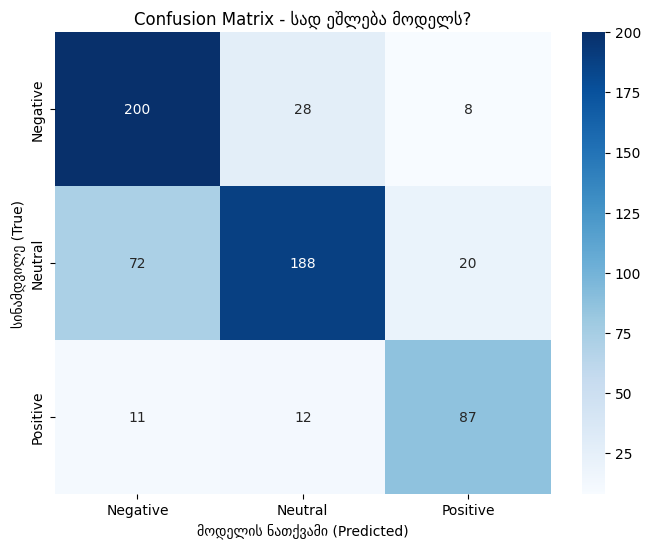

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

all_preds = []
all_labels = []

model.eval()
for i in range(len(tokenized_test)):
    input_ids = tokenized_test[i]["input_ids"].unsqueeze(0).to(device)
    attention_mask = tokenized_test[i]["attention_mask"].unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(input_ids, attention_mask=attention_mask).logits

    all_preds.append(torch.argmax(logits, dim=1).item())
    all_labels.append(tokenized_test[i]["label"].item())

# მატრიცის აგება
cm = confusion_matrix(all_labels, all_preds)
labels = ["Negative", "Neutral", "Positive"]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('მოდელის ნათქვამი (Predicted)')
plt.ylabel('სინამდვილე (True)')
plt.title('Confusion Matrix - სად ეშლება მოდელს?')
plt.show()

In [73]:
model_path = "./final_best_model"  #რეპოზიტორის სახელი
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

labels = ["Negative", "Neutral", "Positive"]

def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        logits = model(**inputs).logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)

    return {labels[i]: float(probabilities[0][i]) for i in range(3)}

demo = gr.Interface(
    fn=predict,
    inputs=gr.Textbox(placeholder="ჩაწერე კომენტარი აქ...", lines=2),
    outputs=gr.Label(num_top_classes=3),
    title="ქართული სოციალური მედიის სენტიმენტ-ანალიზი",
    description="შეიყვანეთ ტექსტი, რათა გაიგოთ, არის ის პოზიტიური, ნეგატიური თუ ნეიტრალური."
)

demo.launch()

The tokenizer you are loading from './final_best_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://86c42cdb5976b9c3ba.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [76]:
import torch
from tqdm.auto import tqdm

# ვიგებ accuracy-ს
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

correct = 0
total = len(tokenized_test)

print("სიზუსტის დათვლა")

for i in tqdm(range(total)):

    inputs = {
        "input_ids": tokenized_test[i]["input_ids"].unsqueeze(0).to(device),
        "attention_mask": tokenized_test[i]["attention_mask"].unsqueeze(0).to(device)
    }
    true_label = tokenized_test[i]["label"].item()

    with torch.no_grad():
        outputs = model(**inputs)

    prediction = torch.argmax(outputs.logits, dim=-1).item()

    if prediction == true_label:
        correct += 1

#შედეგი გამომაქვს პროცენტებში
accuracy = correct / total
print("\n" + "="*30)
print(f"საბოლოო სიზუსტე (Accuracy): {accuracy:.2%}")
print("="*30)

სიზუსტის დათვლა


  0%|          | 0/626 [00:00<?, ?it/s]


საბოლოო სიზუსტე (Accuracy): 75.88%
